In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/monet_tfrec/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/photo_tfrec/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec
/kaggle/input/gan-getting-started/monet_tfrec/monet16-60.tfrec
/kaggle/input/gan-getting-started/monet_tfrec/monet08-60.tfrec
/kaggle/input/gan-getting-started/monet_tfrec/monet04-60.tfrec
/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo10-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo09-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo15-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec

OVERVIEW: 
This notebook uses a cycleGAN (GAN="General Adversarial Network") to turn photos into a Monet-style image. We will construct generator and discriminator 
models. The generator turns photos into Monet-style images through a process of downsampling and upsampling that will be 
described in detail below. The discriminator tries to deduce whether a given image is a real Monet painting or a fake 
created by our generator, i.e. the two networks are "adversarial" in the sense that they have different goals. 
Technically, this is implemented by loss functions, which give the networks specific goals. The generator will have a 
loss function which encourages it to create images to fool the discriminator, whilst the discriminator will have a loss 
function which encourages it to learn the difference between real and fake Monet images. Since this is a cycleGAN, we 
also want photos that are put through the photo->Monet generator followed by the Monet->photo generator to be as close as
possible to the original photo. This is a very important part of the process and will stop the generator from ignoring
the overall goal of creating Monet-style images. A less important, but still useful, loss function that we will use is 
the "identity loss", which compares a photo to its output in the photo generator. When the photo is put through the photo
generator, we want the output to be the same as the input. 

This notebook is based on the following notebook: 
https://www.kaggle.com/amyjang/monet-cyclegan-tutorial#Train-the-CycleGAN

We have added some commentary throughout.

In [2]:
#First, let's setup the TPU accelerator and import the appropriate packages: 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2022-02-19 15:38:32.670530: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-19 15:38:32.670644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-02-19 15:38:37.408936: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-19 15:38:37.411719: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-19 15:38:37.411753: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 15:38:37.411779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d28d0ece1214): /proc/driver/nvidia/version does not exist
2022-02-19 15:38:37.415668: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [3]:
#Now, let's get the TFRecord files...

GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-02-19 15:38:43.687410: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-02-19 15:38:43.771679: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [4]:
"""
Next, we define functions to process and extract the image files. We set the images to be [256,256,3] in dimensions, the 3
coming from the fact that these are in RGB format, so we have an axis for each colour input. The function decode_image
uses the jpeg image decoder to get our image in the required tensor format. This is used in the read_tfrecord function,
which parses the TFRecord files using the "parse_single_example" method, and then decodes the parsed image. We put all
of this in the load_dataset function, which takes the filnames of the TFRecords and creates a dataset from them. We then
use the map method of TFRecordDataset to apply the image parsing and decoding to each file. The mapped dataset is then 
returned and we can directly work with the images since they are now in tensor format. 
"""

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 #rescaling so that all pixel values are between -1 and +1.
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
#Load our datasets in:

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [6]:
#Turn the datasets into iterables so that we easily iterate through them. 

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

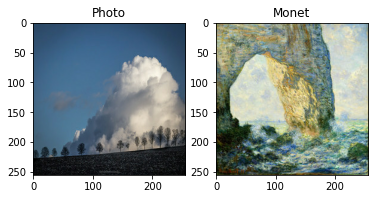

In [7]:
#Let's look at a couple of example images. Note that we first need to rescale our image data so that all values are in [0,1],
#since this is the format expected by the "imshow" method for RGB format. 

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

We now come to the generator and discriminator. We'll start by building the generator, which will be a U-net architecture, so called because the full network has a U-shape. The main idea of this is as follows: we use a maximal number of convolutional layers to minimise the resolution of the image. Each successive convolution gives us knowledge of the features of the image. Then, we use a series of expansive layers which increase the resolution back to the input image resolution. At each expansive layer, we concatenate the input with the output from one of the convolutional layers. This helps use to avoid the problem of the loss function gradient becoming vanishingly small, and also allows us to use the feature information we gained from convolution in the expansion. Thus, the final output should retain the salient features of the input image, but, once the model is trained, it should have a Monet style appearace. This is of course enforced by the loss functions, which we come to later. 

In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#Now we define the generator: 

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections (these are the concatenations we mentioned earlier)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


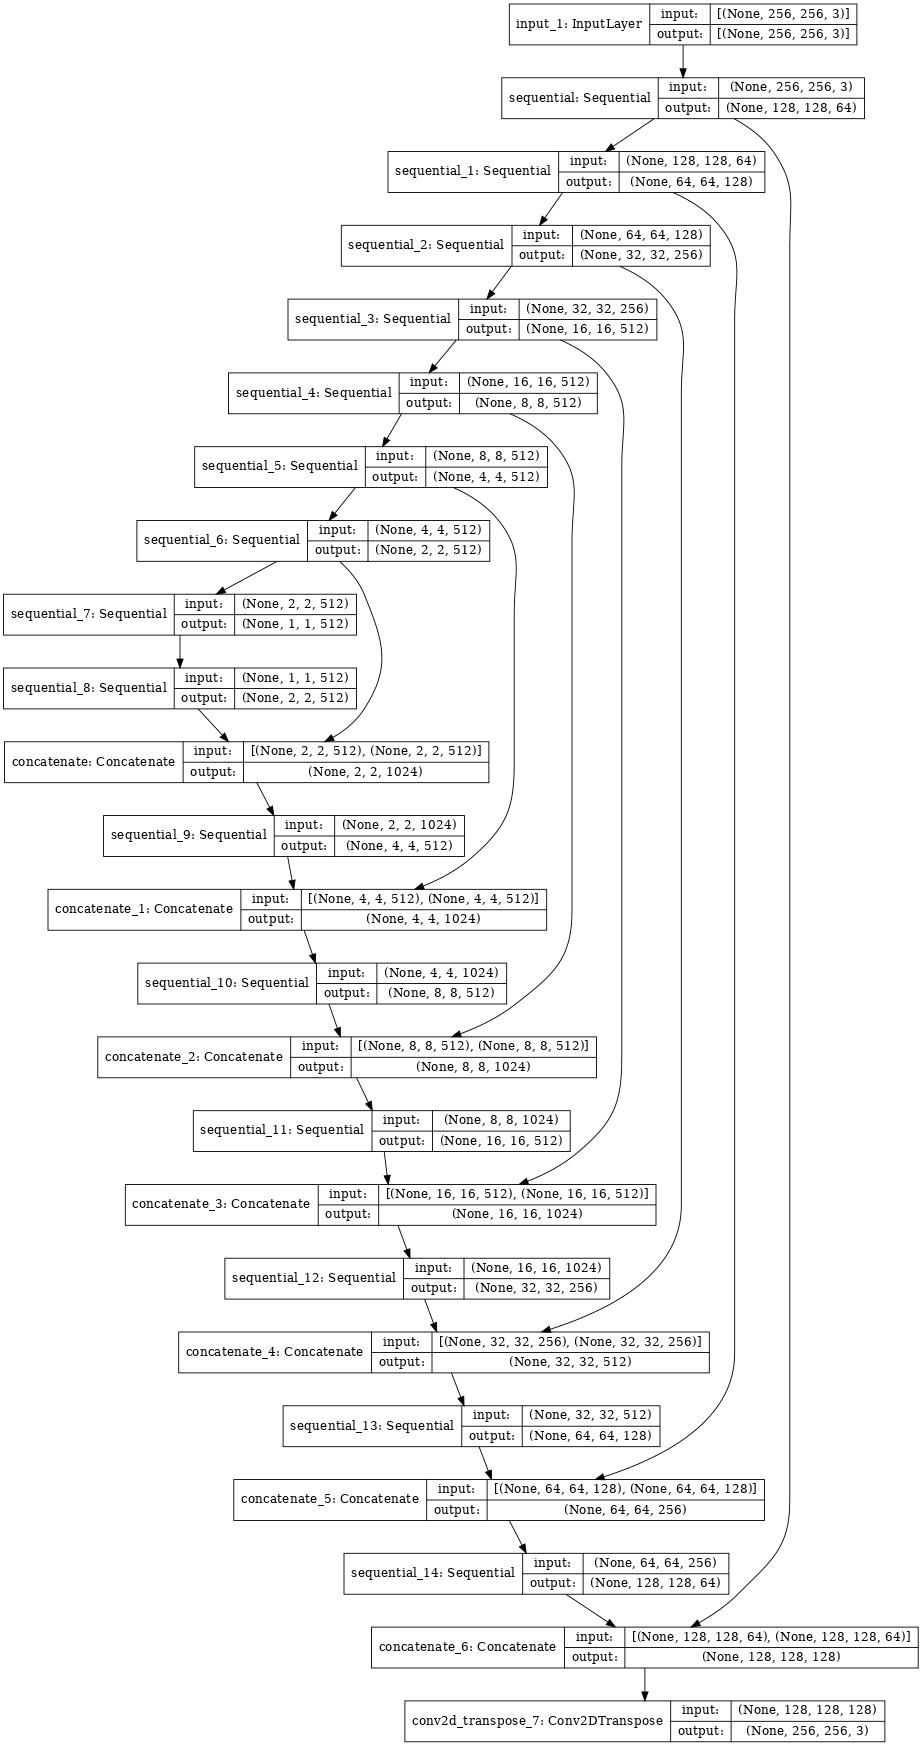

In [9]:
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

Next is the discriminator. This is the network which takes an image as input and determines whether it's a real Monet piece or a real photo (we will have discriminators for both cases). Instead of returning a single value, we will return a smaller image, where higher pixel values correspond to real images and lower correspond to fake images. This way, instead of just having one overall classification, we can look at different sections of the image and get a more informed picture of what's going on. For example, for the Monet discriminator, we may have a monet-like generated image which is accurate in some places, but not so accurate in others, and this is something that the discriminator will be able to pick up on. 

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

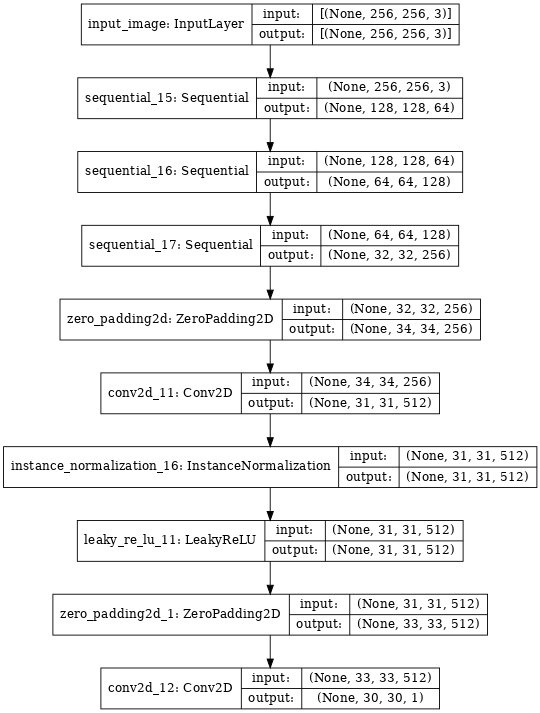

In [11]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

In [12]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

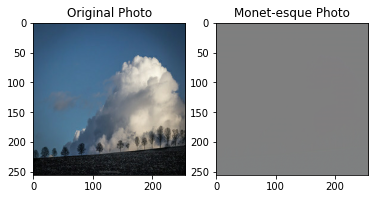

In [13]:
"""
It's good to look at what happens at this point when we put a photo through the generator. Obviously, since we haven't 
trained the generator, it doesn't do anything interesting.
"""

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

We will create a subclass of tf.keras.Model, so that we can use fit() to train the model in the usual way. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another. This will be enforced by the cycle-consistency loss, which we will come to shortly. 
For the subclass, the construction is as follows: we inherit from the keras.Model class, though we also use super() to modify the __init__ and compile methods to include the relevant parameters, optimizers and loss_functions that we have defined above. We then define the training step, which calculates all of the relevant transformations and losses. Finally, we return the total losses. 

In [14]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
             # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        
          # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now we come to the loss functions. Firstly, the discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

Next we have the generator loss. The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

Next we have the cycle consistency loss, which compares an photo to its twice transformed self. We want these to ideally be the same image. Thus, we calculate the cycle consistency loss be finding the average of their difference.

Finally, we have the identity loss. This compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [15]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Now we come to training the model. We will use Adam optimization, which is different to standard stochastic gradient descent in that it has a separate learning rate for each parameter. This generally leads to better optimization performance.

In [16]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [18]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 141s 125ms/step - monet_gen_loss: 5.1818 - photo_gen_loss: 5.4023 - monet_disc_loss: 0.6611 - photo_disc_loss: 0.6165
Epoch 2/25
  1/300 [..............................] - ETA: 51s - monet_gen_loss: 3.0549 - photo_gen_loss: 2.9856 - monet_disc_loss: 0.6413 - photo_disc_loss: 0.6489

2022-02-19 15:41:21.817592: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 13668, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1645285281.814217332","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 13668, Output num: 1","grpc_status":3}


300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.6641 - photo_gen_loss: 3.7542 - monet_disc_loss: 0.6473 - photo_disc_loss: 0.6339
Epoch 3/25
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.5635 - photo_gen_loss: 3.6605 - monet_disc_loss: 0.6529 - photo_disc_loss: 0.6217
Epoch 4/25
300/300 [==============================] - 37s 125ms/step - monet_gen_loss: 3.4919 - photo_gen_loss: 3.5629 - monet_disc_loss: 0.6388 - photo_disc_loss: 0.6215
Epoch 5/25
300/300 [==============================] - 38s 125ms/step - monet_gen_loss: 3.3157 - photo_gen_loss: 3.3674 - monet_disc_loss: 0.6300 - photo_disc_loss: 0.6254
Epoch 6/25
300/300 [==============================] - 38s 125ms/step - monet_gen_loss: 3.2274 - photo_gen_loss: 3.2652 - monet_disc_loss: 0.6190 - photo_disc_loss: 0.6127
Epoch 7/25
300/300 [==============================] - 38s 125ms/step - monet_gen_loss: 3.2140 - photo_gen_loss: 3.2197 - monet_disc_loss: 0.6088 - photo_dis

2022-02-19 15:56:42.205746: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 84885, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1645286202.205563995","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 84885, Output num: 0","grpc_status":3}


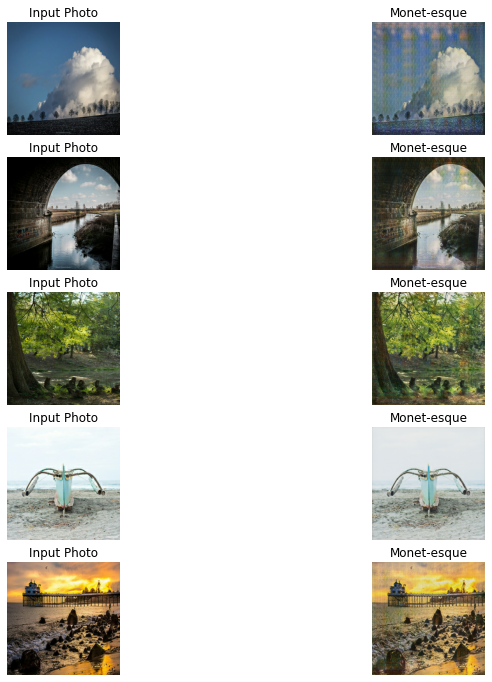

In [19]:
#Let's visualise some of our results: 

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [20]:
#Submission... 

import PIL
! mkdir ../images

In [21]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-02-19 16:31:34.115579: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4659594, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1645288294.115306381","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4659594, Output num: 0","grpc_status":3}


In [22]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'